In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import namedtuple
from tqdm import tqdm, trange
import gymnasium as gym
env = gym.make('CliffWalking-v0')

`CliffWalking` is a grid world environment where the agent starts at the bottom left corner and must navigate to the goal at the bottom right corner. The agent receives a reward of -1 for each step and a reward of -100 for stepping into the cliff. The agent must learn to avoid the cliff and reach the goal as quickly as possible.

Since there is no transition probability, the agent, which is `model-free`, must learn the optimal policy by interacting with the environment. Usually, the agent is expected to choose the action with the highest value, given the current state, while exploring the environment. This is called the $\epsilon$-greedy policy. The agent will choose a random action with probability $\epsilon$ and the action with the highest value with probability $1-\epsilon$. The value of $\epsilon$ is usually set to decrease over time.

$$
a(s; p) = \begin{cases}
\text{random action} & p < \epsilon \\
\arg\max\limits_a Q(s, a) & p \geq \epsilon
\end{cases}\quad p \sim \mathcal{U}(0, 1)
$$

Below are two different algorithms to evaluate the policy for model-free reinforcement learning, `Mento Carlo` and `Temporal Difference`. The difference between the two is that `Monte Carlo` only updates the value of the state-action pair after the episode is finished, while `Temporal Difference` updates the value of the state-action pair after each step. The `Temporal Difference` algorithm is more efficient since it does not have to wait until the end of the episode to update the value of the state-action pair.

- Monte Carlo

$$
V(s_t) \leftarrow V(s_t) + \alpha \left( G_t - V(s_t) \right)
$$

- - $G_t$ is the return of the episode
- - $\alpha$ is the learning rate
- - $V(s_t)$ is the value of the state at time $t$

- Temporal Difference

$$
V(s_t) \leftarrow V(s_t) + \alpha \left( r_{t+1} + \gamma V(s_{t+1}) - V(s_t) \right)
$$

- - $r_{t+1}$ is the reward at time $t+1$
- - $\gamma$ is the discount factor
- - $V(s_{t+1})$ is the value of the state at time $t+1$

- $n$-step Temporal Difference

$$
V(s_t) \leftarrow V(s_t) + \alpha \left( G_{t:t+n} - V(s_t) \right)
$$

- - $G_{t:t+n}$ is the $n$-step return

$$
G_{t:t+n} = r_{t+1} + \gamma r_{t+2} + \cdots + \gamma^{n-1} r_{t+n} + \gamma^n V(s_{t+n})
$$

`Temporal Difference` is a special case of `n-step Temporal Difference` where $n=1$. If $n$ is close to the length of the episode, then the `TD` algorithm is similar to the `MC` algorithm.

In [2]:
n_actions = env.action_space.n
env.action_space.__dict__

{'n': 4, 'start': 0, '_shape': (), 'dtype': dtype('int64'), '_np_random': None}

In [3]:
n_states = env.observation_space.n
env.observation_space.__dict__

{'n': 48,
 'start': 0,
 '_shape': (),
 'dtype': dtype('int64'),
 '_np_random': None}

In [4]:
observation, info = env.reset()
print(f"The agent starts in state {observation}")

The agent starts in state 36


In [5]:
max_episodes = 500 # number of training episodes
max_steps_per_episode = 10000 # prevent infinite loops

# Q-learning and SARSA

`Q-learning` and `SARSA` are two algorithms that learn the optimal policy for model-free reinforcement learning. The difference between the two is that `Q-learning` chooses the action with the highest value, while `SARSA` requires actually taking the action and observing the next state and the next action before updating the value of the state-action pair. `Q-learning` is an off-policy algorithm (because it chooses the action with the highest value, which may not be the action that the agent actually takes), while `SARSA` is an on-policy algorithm.

- Q-learning

$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left( r_{t+1} + \gamma \max\limits_a Q(s_{t+1}, a) - Q(s_t, a_t) \right)
$$

- SARSA

$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left( r_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t) \right)
$$

Below is an example of `Q-learning` and `SARSA` on the `CliffWalking` environment. The agent learns to avoid the cliff and reach the goal as quickly as possible.

In [6]:
class model_free_agent:
    def __init__(self, n_states, n_actions, epsilon=.99, learning_rate=.1, gamma=.9):
        self.n_states = n_states
        self.n_actions = n_actions
        self.epsilon = epsilon # exploration rate
        self.gamma = gamma # discount factor
        self.learning_rate = learning_rate # learning rate
        self.q_table = np.zeros((n_states, n_actions)) # initialize Q-table with zeros
        self.count_table = np.zeros((n_states, n_actions)) # initialize count table with zeros
    
    def act(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            # explore
            action = np.random.choice(self.n_actions)
        else:
            # exploit
            action = np.argmax(self.q_table[state])
        return action
    
    def learn(self, state, action, reward, next_state, done):
        # update q_table
        q_predict = self.q_table[state, action]
        if done:
            q_target = reward
        else:
            q_target = reward + self.gamma * np.max(self.q_table[next_state])
        self.q_table[state, action] += self.learning_rate * (q_target - q_predict)

    def learn_sarsa(self, state, action, reward, next_state, next_action):
        # update q_table
        self.q_table[state, action] += self.learning_rate * (reward + self.gamma * self.q_table[next_state, next_action] - self.q_table[state, action])
    
    def update_epsilon(self):
        self.epsilon = self.epsilon * .99

In [7]:
agent = model_free_agent(n_states, n_actions)
sarsa_agent = model_free_agent(n_states, n_actions)

In [8]:
ql_rewards = []
for episode in trange(max_episodes):
    observation, info = env.reset()
    total_reward = 0
    for step in range(max_steps_per_episode):
        action = agent.act(observation)
        # print(f"Agent performed action {action}")
        new_observation, reward, terminated, truncated, info = env.step(action) # perform the action
        total_reward += reward
        # print(f"Agent moved from state {observation} to state {new_observation} and received reward {reward}")

        # q-learning update
        agent.learn(observation, action, reward, new_observation, terminated)

        if terminated:
            # print(f"Episode {episode + 1} ended after {step + 1} steps")
            break
        if truncated:
            # print(f"Episode {episode + 1} truncated after {step + 1} steps")
            break
        observation = new_observation # update the state
    # print(f"The length of episode {episode + 1} is {len(ep_reward)}")
    ql_rewards.append((total_reward, step + 1))
    agent.update_epsilon()

100%|██████████| 500/500 [00:01<00:00, 455.16it/s]


In [9]:
# sarsa_rewards = []
# for episode in trange(max_episodes):
#     observation, info = env.reset()
#     total_reward = 0
#     old_action = None
#     old_state = None
#     old_reward = None
#     for step in range(max_steps_per_episode):
#         # action = env.action_space.sample()
#         action = sarsa_agent.act(observation)
#         # print(f"Agent performed action {action}")
#         new_observation, reward, terminated, truncated, info = env.step(action)
#         # print(f"Agent moved from state {observation} to state {new_observation} and received reward {reward}")
#         total_reward += reward

#         if old_action is not None:
#             sarsa_agent.learn_sarsa(old_state, old_action, old_reward, observation, action)

#         if terminated:
#             # print(f"Episode {episode + 1} ended after {step + 1} steps")
#             break
#         if truncated:
#             print(f"Episode {episode + 1} truncated after {step + 1} steps")
#             break
            
#         old_action = action
#         old_state = observation
#         old_reward = reward

#     sarsa_rewards.append((total_reward, step + 1))
#     sarsa_agent.update_epsilon()

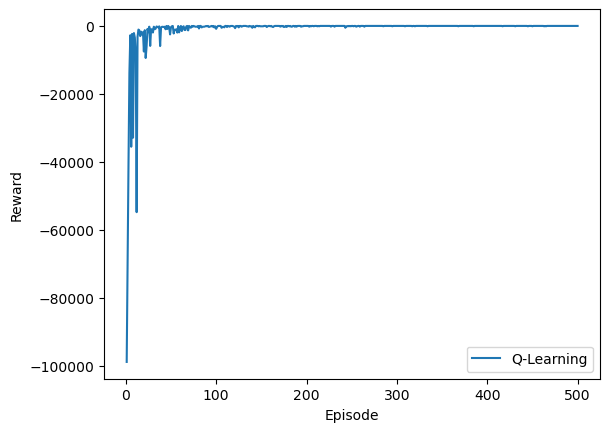

In [10]:
# plt.plot(range(1, len(sarsa_rewards) + 1), [r[0] for r in sarsa_rewards], label="SARSA")
plt.plot(range(1, len(ql_rewards) + 1), [r[0] for r in ql_rewards], label="Q-Learning")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()

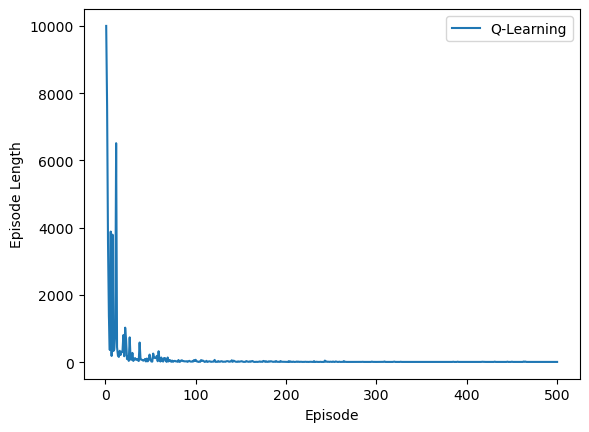

In [11]:
# plt.plot(range(1, len(sarsa_rewards) + 1), [r[1] for r in sarsa_rewards], label="SARSA")
plt.plot(range(1, len(ql_rewards) + 1), [r[1] for r in ql_rewards], label="Q-Learning")
plt.xlabel("Episode")
plt.ylabel("Episode Length")
plt.legend()
plt.show()

Using the maximum value of the action at the current state to represent the value of the state, the visualization of the value of the state is shown below. 

$$
V(s_t) = \max\limits_a Q(s_t, a)
$$

Since the reward is negative for each step, the value of the state is also negative. The reason why the value of the cliff is the same as the initialization value is that the agent will never choose to step into the cliff so that the value of the cliff will never be updated, as well as the value of the goal state.

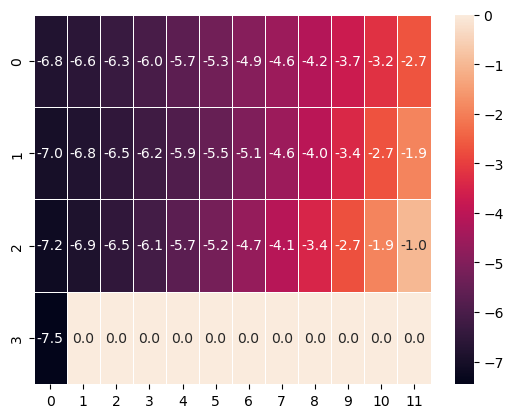

In [12]:
value_of_state = np.max(agent.q_table, axis=1).reshape((4, 12))
sns.heatmap(value_of_state, annot=True, fmt=".1f", linewidths=.5)
plt.show()